## Evaluation of the loss functions used in CHRS calibration of GLWA model

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Import loss functions
from loss_functions_dtw import SoftDTW
from pinnwmm_losses import LogCoshLoss

We create a synthetic measured signal that we will use to evaluate other signals.

In [2]:
## Create a measued signal
def storm_response(lenght=500,
                   base_flow_level=10.0,
                   peak=5.0,
                   peak_start=120,
                   peak_end=130,
                   base_flow_frequency=0.006,
                   diurnal_flow_frequency=0.050,
                   wet_weather_frequency=0.1):
    time_horizon = np.linspace(0, lenght, lenght) * np.pi
    diural_signal = np.sin(diurnal_flow_frequency * time_horizon)
    base_flow = np.sin(base_flow_frequency * time_horizon) * 0.20 + base_flow_level
    wet_weather_flow = np.abs(np.sin(wet_weather_frequency * time_horizon[peak_start:peak_end]) * peak)
    signal = diural_signal + base_flow
    signal[peak_start:peak_end] += wet_weather_flow
    return signal

In [3]:
measured_signal = storm_response()

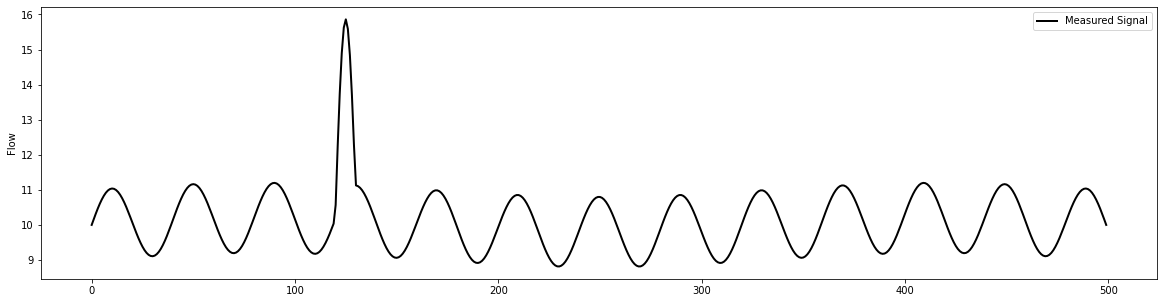

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(measured_signal, label='Measured Signal', linewidth=2.0, color='k')
plt.ylabel("Flow")
plt.legend()

Lets generate modeled signals that we can test to see how losses are behaving.

In [5]:
# Modeled signals
modeled_signals = {}

# flat lines with varying intensities
length_horizon = 500

mean_level = 10.0
levels = [-2.0, -1.0, 0.0, 1.0, 2.0, -3.0, 3.0]
for level in levels:
    modeled_signals[f"flat_line_{level}"] = np.ones(500) * (mean_level + level)

In [6]:
# diurnal signals
# shift the timing
frequencies_diurnal = [0.050, 0.060, 0.030, 0.010]
levels = [-2.0, -1.0, 0.0, 1.0, 2.0, -3.0, 3.0]
for freq in frequencies_diurnal:
    modeled_signals[f"diurnal_timing_{freq}"] = storm_response(diurnal_flow_frequency=freq)
for level in levels:
    modeled_signals[f"diurnal_level_{level}"] = storm_response(base_flow_level=10.0 + level)
for freq in frequencies_diurnal:
    for level in levels:
        modeled_signals[f"diurnal_level_{level}_timing_{freq}"] = storm_response(base_flow_level=10.0 + level, diurnal_flow_frequency=freq)


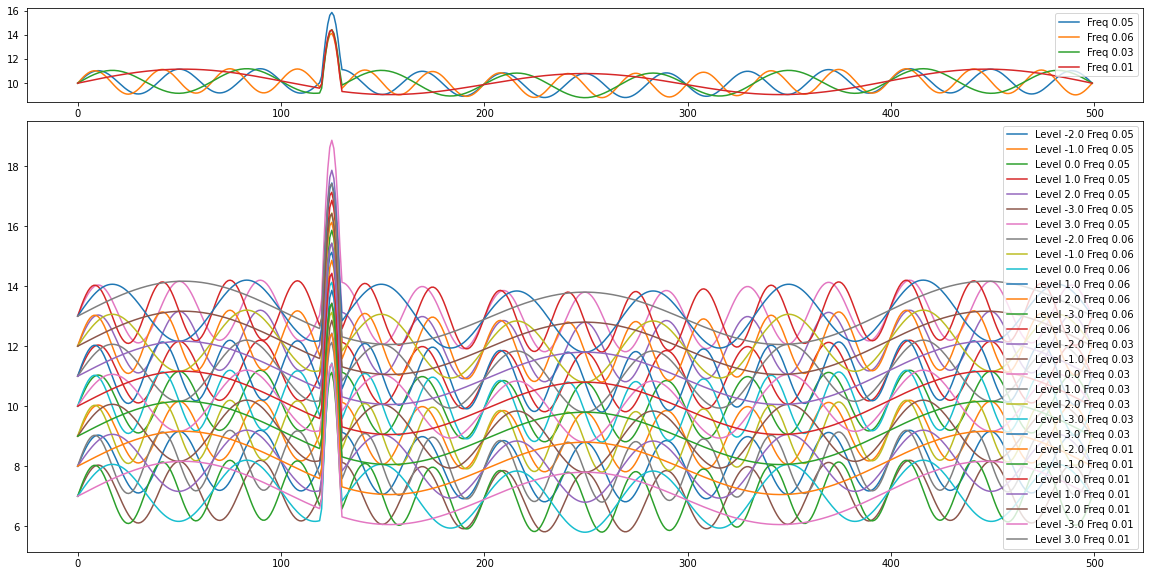

In [7]:
plt.figure(figsize=(20, 10))

plt.subplot(5, 1, 1)
for freq in frequencies_diurnal:
    plt.plot(modeled_signals[f"diurnal_timing_{freq}"], label=f"Freq {freq}")
plt.legend()

plt.subplot(5, 1, (2,5))
for freq in frequencies_diurnal:
    for level in levels:
        plt.plot(modeled_signals[f"diurnal_level_{level}_timing_{freq}"], label=f"Level {level} Freq {freq}")
plt.legend()

In [8]:
# shift the peak
peakshifts = [(130, 140), (200, 210), (50, 60), (400,410)]
for peakshift in peakshifts:
    modeled_signals[f"Peak_shift_{peakshift[0]}_{peakshift[1]}"] = storm_response(peak_start=peakshift[0], peak_end=peakshift[1])

peakshifts = [(130, 140), (200, 210), (50, 60), (400,410)]
for peakshift in peakshifts:
    for level in levels:
        modeled_signals[f"Peak_shift_{peakshift[0]}_{peakshift[1]}_Level_{level}"] = storm_response(base_flow_level=10.0 + level, peak_start=peakshift[0], peak_end=peakshift[1])

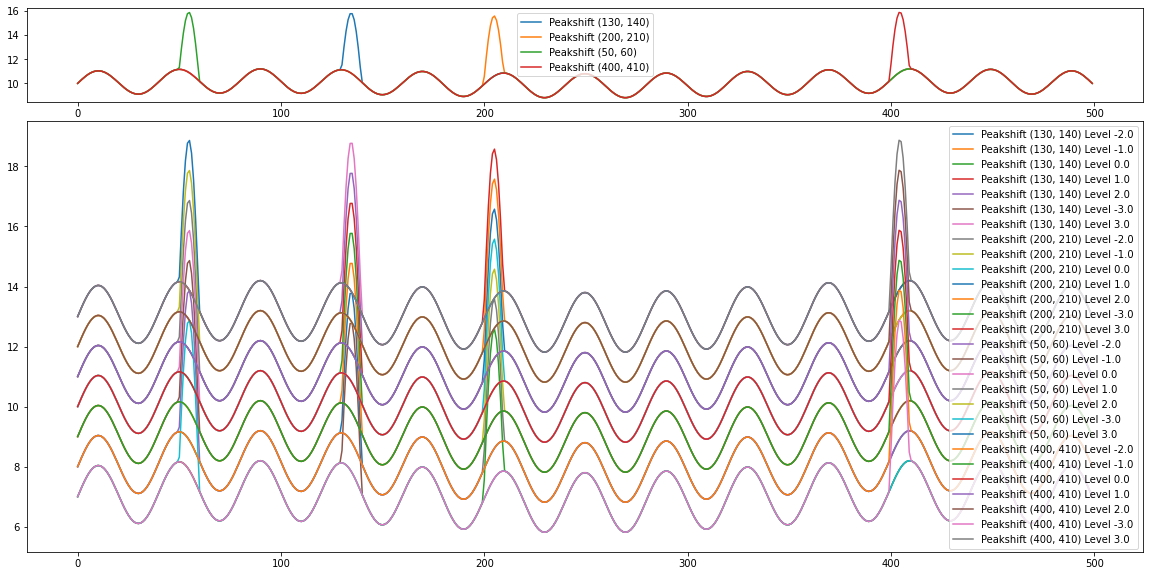

In [9]:
plt.figure(figsize=(20, 10))

plt.subplot(5, 1, 1)
for peakshift in peakshifts:
    plt.plot(modeled_signals[f"Peak_shift_{peakshift[0]}_{peakshift[1]}"], label=f"Peakshift {peakshift}")
plt.legend()

plt.subplot(5, 1, (2,5))
for peakshift in peakshifts:
    for level in levels:
        plt.plot(modeled_signals[f"Peak_shift_{peakshift[0]}_{peakshift[1]}_Level_{level}"], label=f"Peakshift {peakshift} Level {level}")
plt.legend()

In [10]:
# This the same implementation as pinswmm
sdtw = SoftDTW(False, gamma=1.0, normalize=False)
sdtw_normalized = SoftDTW(False, gamma=1.0, normalize=True)
mse = torch.nn.MSELoss(reduction='sum')
l1 = torch.nn.L1Loss(reduction='sum')
log_cosh = LogCoshLoss()

In [12]:
# compute losses
losses = {}
loss_functions = [("DTW", sdtw_normalized), ('DTW Normalized', sdtw_normalized), ('MSE', mse), ('L1', l1), ('LogCosh', log_cosh)]
for loss_function in loss_functions:
    losses[loss_function[0]] = {}
    for modeled_flow in modeled_signals.keys():
        x = torch.from_numpy(measured_signal.reshape(measured_signal.shape[0], 1, 1))
        y = torch.from_numpy(modeled_signals[modeled_flow].reshape(modeled_signals[modeled_flow].shape[0], 1, 1))
        losses[loss_function[0]][modeled_flow] = loss_function[1](x, y).numpy().flatten()
    losses[loss_function[0]] = pd.DataFrame(losses[loss_function[0]])

In [13]:
losses_sum_average = {}
for key1 in losses:
    losses_sum_average[key1] = {}
    losses_sum_average[key1]['name'] = []
    losses_sum_average[key1]['values'] = []
    for key2 in losses[key1]:
        losses_sum_average[key1]['values'].append(losses[key1][key2].sum())
        losses_sum_average[key1]['name'].append(key2)

In [14]:
modeled_flows_df = pd.DataFrame.from_dict(modeled_signals)

In [ ]:
for column in modeled_signals.keys():
    plt.figure(figsize=(20, 5), dpi=100)
    plt.plot(modeled_signals[column], linewidth=2.0, color='b', label='Modeled Signal')
    plt.plot(measured_signal, linewidth=2.0, color='k', label='Target Signal')
    for loss_function in losses.keys():
        if loss_function in ['DTW', 'DTW Normalized']:
            if loss_function == "DTW":
                plt.plot(losses[loss_function][column], label=loss_function, linestyle='--')
            else:
                plt.plot(losses[loss_function][column], label=loss_function, linestyle='-')
    plt.legend()
    #plt.ylim([0, max(max(losses[loss_function][column]), max(modeled_signals[column]), max(measured_signal))])
    plt.savefig(f"./{column}.png", facecolor='white')

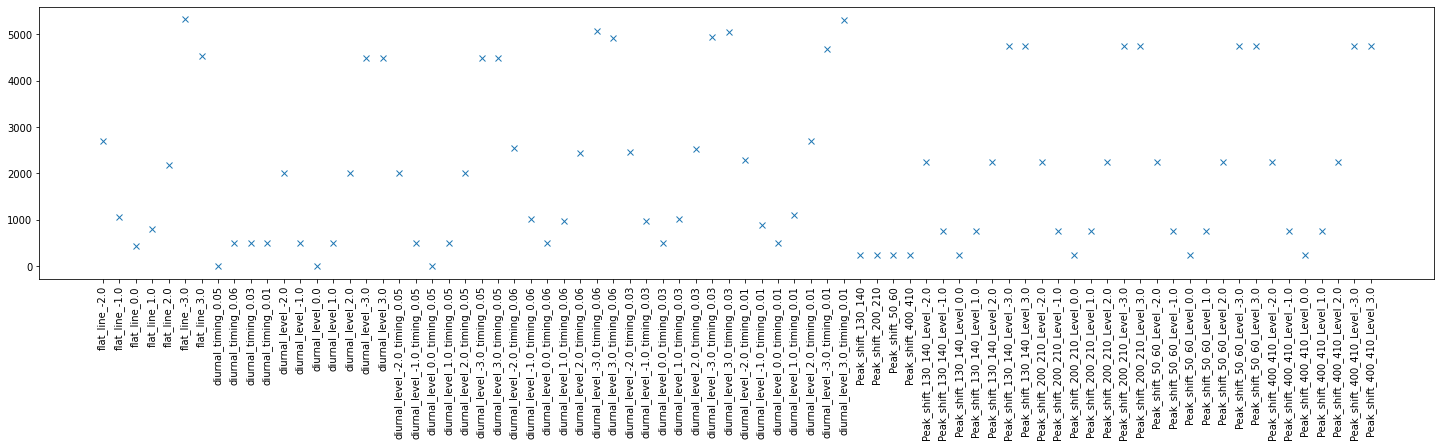

In [15]:
fig = plt.figure(figsize=(25, 5))
ax = plt.gca()
sum_losses = losses['DTW'].sum().values.flatten()
index_losses = list(losses['DTW'].columns)
xn = np.linspace(0, len(index_losses), len(index_losses))
plt.plot(xn, sum_losses, 'x')
plt.xticks(xn, index_losses, rotation='vertical')
plt.show()

In [16]:
# make the sum of loss into a dataframe
multi_loss_function = pd.DataFrame()
multi_loss_function['DTW'] = losses['DTW'].sum().T
multi_loss_function['DTW Normalized'] = losses['DTW Normalized'].sum().T
multi_loss_function['MSE'] = losses['MSE'].T
multi_loss_function['L1'] = losses['L1'].T
multi_loss_function['LogCosh'] = losses['LogCosh'].T

<AxesSubplot:>

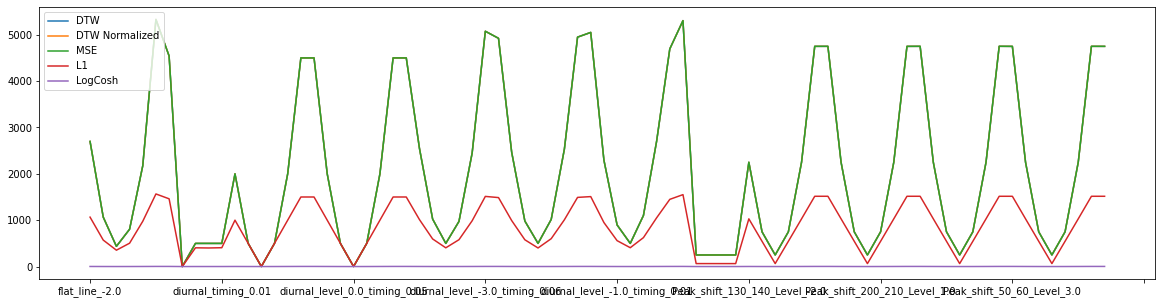

In [23]:
plt.figure(figsize=(20, 5))
ax = plt.gca()
multi_loss_function.plot(ax=ax)

<AxesSubplot:>

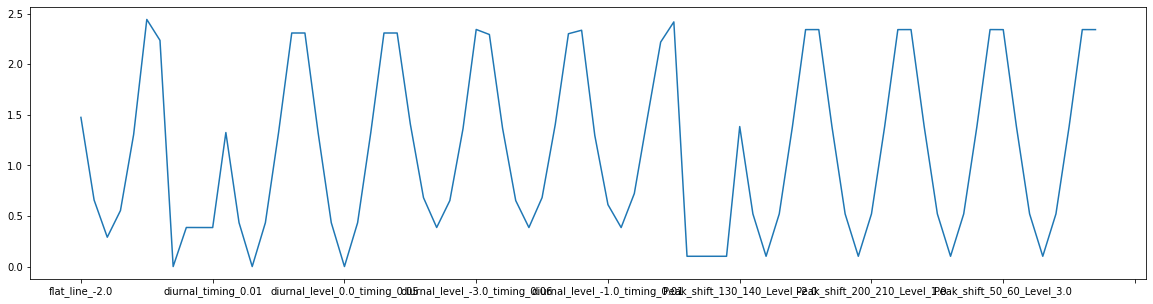

In [26]:
plt.figure(figsize=(20, 5))
ax = plt.gca()
multi_loss_function['LogCosh'].plot()

DTW losses are non-linear 
DTW is dependent on magniture 
DTW with shift, you get two peaks.